In [1]:
import requests
import pandas as pd
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt
import shapely
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from skimage.segmentation import quickshift
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import math
import random
import statistics
import glob
import concurrent.futures
import glob
import ast
import sys
import gc

sys.path.append('../scripts')
from create_dataset import generate_dataset
from supervised_models import generate_resnet

Image.MAX_IMAGE_PIXELS = None

In [2]:
## Retrieve census data for specified location(s) and geography type (e.g., block group)

# Read the downloaded scenes metadata
metadata_df = pd.read_csv("../data/output/downloaded_scenes_metadata.csv")

# Specify the file path of the text file
fips_path = "../data/FederalCodes_National.txt"

# Read the text file using pandas, specifying the column data types
fips_df = pd.read_csv(fips_path, sep="|", low_memory=False)

# Define a dictionary mapping state names to their corresponding FIPS codes
state_fips_path = "../data/state_fips.txt"
with open(state_fips_path, "r") as file:
    state_fips_content = file.read()
state_codes = ast.literal_eval(state_fips_content)

# Define a dictionary mapping state names to their abbreviations
state_abbrev_path = "../data/state_abbrev.txt"
with open(state_abbrev_path, "r") as file:
    state_abbrev_content = file.read()
state_abbrevs = ast.literal_eval(state_abbrev_content)

# Replace YOUR_API_KEY_HERE with your own API key
API_KEY = "bd041cbc149095f7871a9d002c6ca41d7b8010ef"

# Define the API endpoint
url = "https://api.census.gov/data/{year}/acs/acs5"

# Define the variables and geography of interest
variables = "B19013_001E"
geography = "block group:*"

# Initialize an empty list to store the results
dfs = []

# Initialize a set to store unique city-state combinations
processed_combinations = set()

# Loop over each row in the metadata DataFrame
for _, row in metadata_df.iterrows():
    city = row["city"]
    state = row["state"]
    year = row["year"]

    combination = (city, state)
    
    # Skip if the combination has already been processed
    if combination in processed_combinations:
        continue

    # Add the combination to the processed set
    processed_combinations.add(combination)

    # Ignore anomalous cities with incongruent imagery years compared to rest of state
    if city == 'miami' and state == 'fl':
        print('!!!!! NOTICE: skipping miami, fl due to year !!!!!')
        continue
    if city == 'spokane' and state == 'wa':
        print('!!!!! NOTICE: skipping spokane, wa due to year !!!!!')
        continue
    
    # Find county code(s) for the city in the fips_df DataFrame
    for name, abbreviation in state_abbrevs.items():
        if abbreviation == state.upper():
            full_state_name = name
            break
    city_county_df = fips_df[(fips_df["feature_name"].str.contains("City of " + city.title().replace("_", " "))) & (fips_df["state_name"] == full_state_name)]
    county_sequence_values = city_county_df["county_numeric"].astype(str).str.zfill(3).tolist()

    # Remove duplicates from county_sequence_values
    county_sequence_values = list(set(county_sequence_values))

    # Join multiple county codes with a comma
    county_sequence = ",".join(map(str, county_sequence_values))

    # Handle anomalies
    if city == 'nashville' and state == 'tn':
        county_sequence = '037'
    if city == 'lexington' and state == 'ky':
        county_sequence = '067'   

    print(f'{city}, {state}; county code(s): {county_sequence}; year: {year}')

    # Define the location of interest
    location = f"state:{state_codes[state]}+county:{county_sequence}+tract:*"

    # Build the API query
    query = f"{url.format(year=year)}?get={variables}&for={geography}&in={location}&key={API_KEY}"

    try:
        # Make the API call
        response = requests.get(query)

        # Parse the response as JSON
        acs_data = response.json()

        # Convert the list to a DataFrame
        temp_df = pd.DataFrame(acs_data[1:], columns=acs_data[0])
        # Add the year column to the DataFrame
        temp_df["year"] = year

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    except requests.exceptions.JSONDecodeError as err:
        print(f"!!!!! NOTICE: error for {city}, {state}: {err} !!!!!")
        continue

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
df

seattle, wa; county code(s): 033; year: 2019
new_york, ny; county code(s): 061,081,005,047,085; year: 2021
los_angeles, ca; county code(s): 037; year: 2020
chicago, il; county code(s): 043,031; year: 2021
oakland, ca; county code(s): 001; year: 2020
dallas, tx; county code(s): 121,397,257,085,113; year: 2020
washington, dc; county code(s): 001; year: 2021
houston, tx; county code(s): 157,473,339,201; year: 2020
boston, ma; county code(s): 025; year: 2021
philadelphia, pa; county code(s): 101; year: 2019
atlanta, ga; county code(s): 121,089; year: 2019
san_jose, ca; county code(s): 085; year: 2020
!!!!! NOTICE: skipping miami, fl due to year !!!!!
phoenix, az; county code(s): 013; year: 2021
minneapolis, mn; county code(s): 053; year: 2021
detroit, mi; county code(s): 163; year: 2020
san_diego, ca; county code(s): 073; year: 2020
aurora, co; county code(s): 001,005,035; year: 2019
baltimore, md; county code(s): 510; year: 2021
riverside, ca; county code(s): 065; year: 2020
charlotte, nc

,B19013_001E,state,county,tract,block group,year
0,90682,53,033,025702,2,2019
1,101806,53,033,025702,1,2019
2,55761,53,033,026400,5,2019
3,69205,53,033,026400,3,2019
4,37379,53,033,027100,1,2019
...,...,...,...,...,...,...
84268,94940,06,095,253404,4,2020
84269,68581,06,095,253501,2,2020
84270,-666666666,06,095,253501,3,2020
84271,52819,06,095,253502,2,2020


In [3]:
## Analyze state-year combinations in dataframe

# Group the DataFrame by state and year, and count the unique years for each state
state_year_counts = df.groupby(['state'])['year'].nunique().reset_index().rename(columns={'year': 'year_count'})

# Filter for states with more than one year
filtered_states = state_year_counts[state_year_counts['year_count'] > 1]

print("Year differences:")
# Check if there are states with more than one year
if len(filtered_states) > 0:
    # Loop over the filtered states and print the state, county, and years
    for _, row in filtered_states.iterrows():
        state = row['state']
        years = df.loc[df['state'] == state, 'year'].unique()
        county = df.loc[df['state'] == state, 'county'].iloc[0]

        print(f"State: {state}, Years: {', '.join(map(str, years))}")
else:
    print("There are no states with more than one year.")

unique_states_count = df['state'].nunique()
print("Number of states:", unique_states_count)

Year differences:
There are no states with more than one year.
Number of states: 40


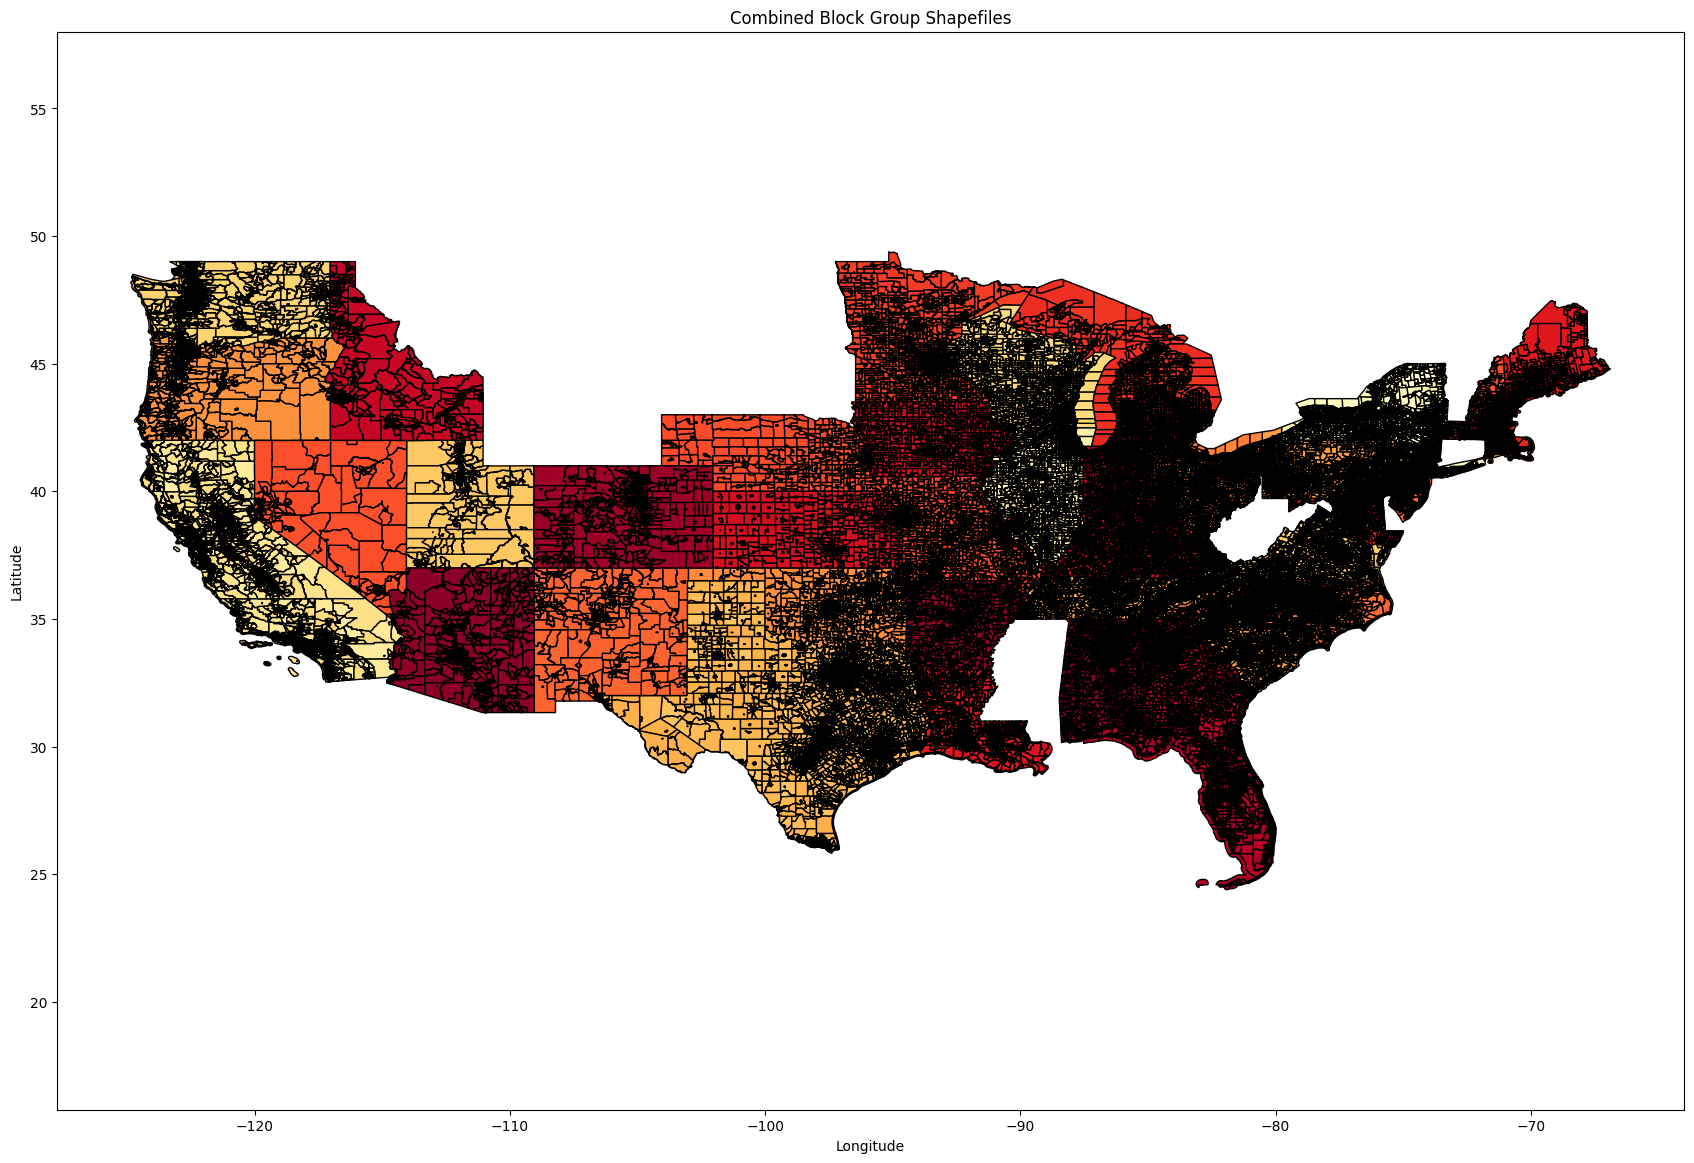

In [4]:
## Unzip and show block group shapefiles

# Path to the directory containing the ZIP files
zip_directory = "../data/state_block_group_shapefiles/"

# Get a list of all ZIP files in the directory
zip_files = glob.glob(zip_directory + "*.zip")

# Create an empty list to store the GeoDataFrame objects
gdf_list = []

# Loop over each ZIP file
for zip_file in zip_files:
    # Get the name of the extracted shapefile
    shapefile_name = zip_file.replace(".zip", ".shp")

    # Check if the shapefile has already been extracted
    if not os.path.exists(shapefile_name):
        # Extract the shapefile from the zip archive
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(zip_directory)

    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile_name)

    # Append the current GeoDataFrame to the list
    gdf_list.append(gdf)

# Combine all GeoDataFrame objects into a single GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

# Plot the combined GeoDataFrame
fig, ax = plt.subplots(figsize=(21, 14))
combined_gdf.plot(ax=ax, cmap='YlOrRd', edgecolor='k')

# Customize the plot appearance
ax.set_title("Combined Block Group Shapefiles")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.axis('equal')

# Display the plot
plt.show()


In [96]:
# merge census API and shapefile dataframes, drop N/A values, and sort

# Merge the shapefile and API dataframes
merged_df = pd.merge(combined_gdf, df, left_on=['BLKGRPCE', 'TRACTCE', 'COUNTYFP', 'STATEFP'], right_on=['block group', 'tract', 'county', 'state'], how='inner')

# Drop N/A values in the median household income column
merged_df['B19013_001E'] = pd.to_numeric(merged_df['B19013_001E'], errors='coerce')
merged_df = merged_df[merged_df['B19013_001E'] != -666666666]

# Sort the dataframe by median household income in descending order
merged_df = merged_df.sort_values(by='B19013_001E', ascending=False)

# Display the merged and sorted dataframe
pd.set_option('display.max_rows', False)
# Convert the DataFrame to a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')
print(merged_df[['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'B19013_001E', 'geometry']])

      STATEFP COUNTYFP TRACTCE BLKGRPCE  B19013_001E   
44924      47      037  018500        3       250001  \
20894      06      037  670324        3       250001   
20526      06      085  511400        1       250001   
20527      06      085  511400        3       250001   
20528      06      085  511400        4       250001   
20549      06      083  000103        1       250001   
68940      25      025  070600        2       250001   
68903      25      025  010103        2       250001   
21199      06      037  670328        2       250001   
...       ...      ...     ...      ...          ...   
38578      48      201  211102        1         2499   
68094      25      025  010204        1         2499   
53892      39      035  120802        2         2499   
52130      40      027  201202        2         2499   
46194      47      093  000902        1         2499   
10798      17      031  420700        4         2499   
76438      12      057  003100        3         

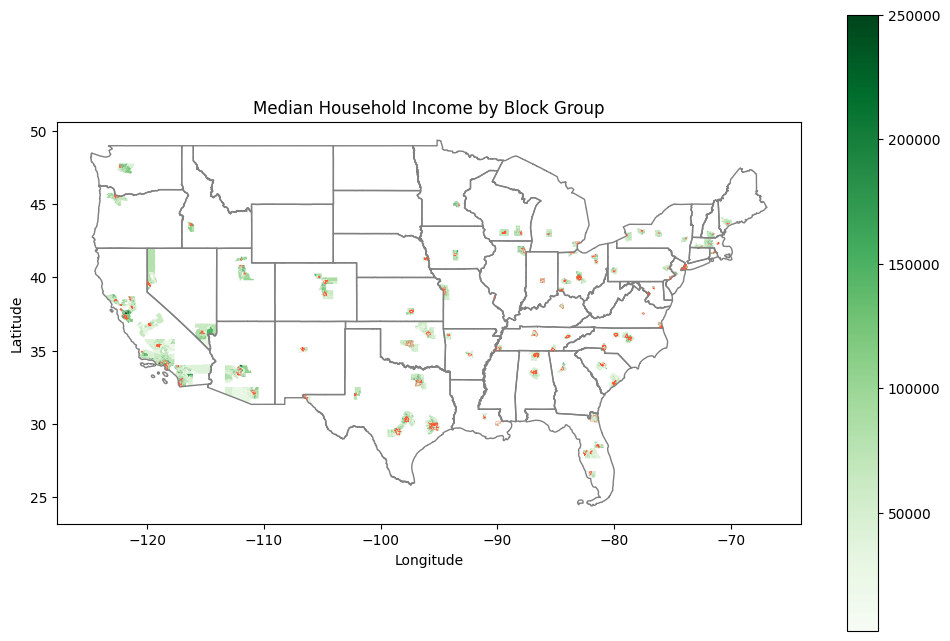

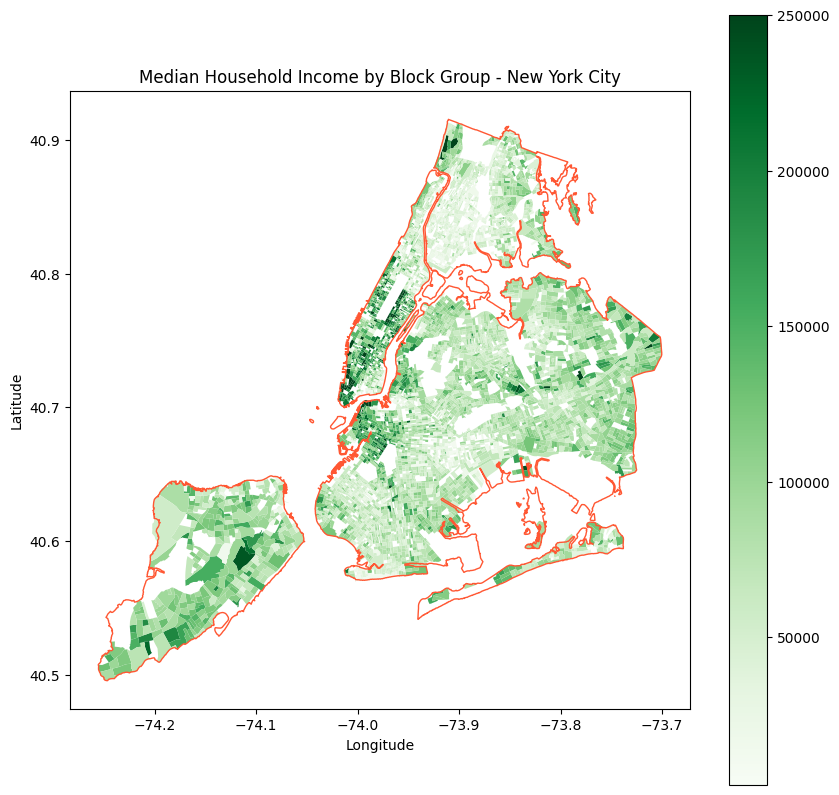

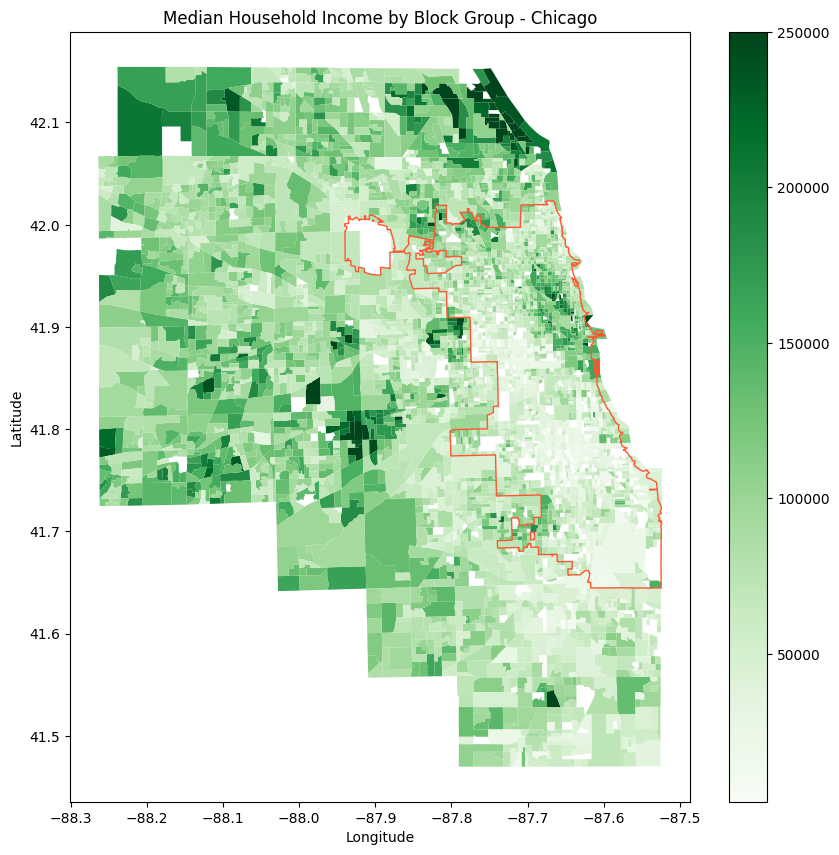

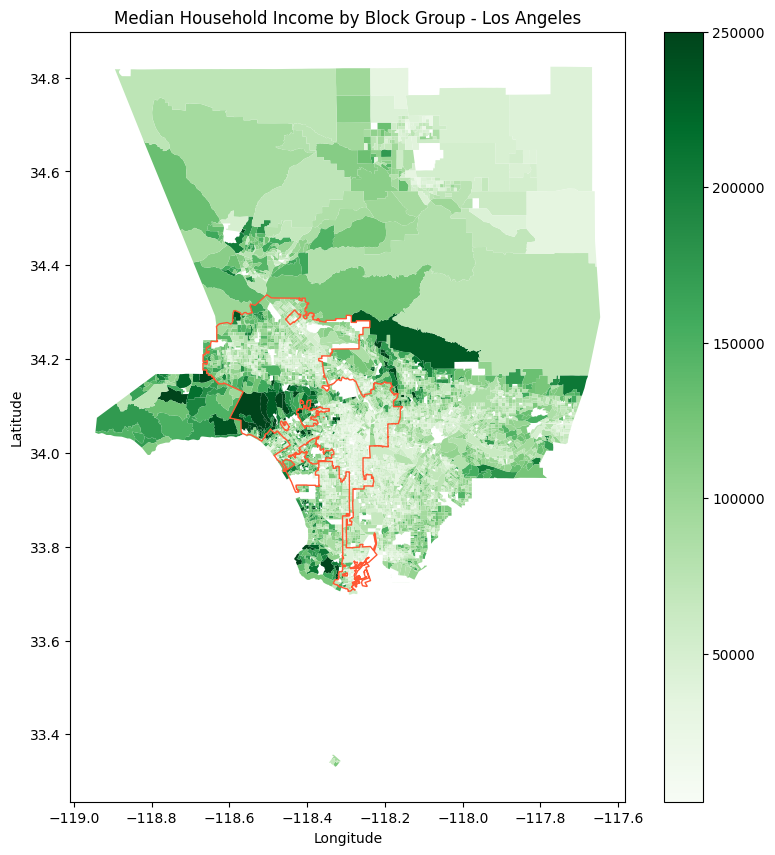

In [102]:
## Show city boundaries and heat map of block groups by median household income for USA, NYC, Chicago, and LA

# Load the shapefiles containing boundaries
usa_boundary = gpd.read_file('../data/city_boundaries/USA/')
city_boundaries = gpd.read_file('../data/city_boundaries/all/')
# Convert city and state columns in city_boundaries to lowercase with underscores
city_boundaries['city'] = city_boundaries['NAME'].apply(lambda x: x.lower().replace(" ", "_"))
city_boundaries['state'] = city_boundaries['ST'].apply(lambda x: x.lower())
# Convert city and state columns in metadata_df to lowercase with underscores and lowercase
metadata_df['city'] = metadata_df['city'].apply(lambda x: x.lower().replace(" ", "_"))
metadata_df['state'] = metadata_df['state'].apply(lambda x: x.lower())
# Merge city_boundaries with metadata_df on city and state columns
merged_cities = city_boundaries.merge(metadata_df, on=['city', 'state'], how='inner')
# Exclude anomalies
excluded_cities = ['miami', 'spokane']
excluded_states = ['ct']
final_city_boundaries = merged_cities[
    ~((merged_cities['city'].isin(excluded_cities)) | (merged_cities['state'].isin(excluded_states)))
]
# Drop duplicates based on 'city' and 'state' columns
final_city_boundaries = final_city_boundaries.drop_duplicates(subset=['city', 'state'])
# Set the active geometry column
final_city_boundaries = final_city_boundaries.set_geometry('geometry_x')
final_city_boundaries = final_city_boundaries.to_crs("EPSG:4269")


# Display total US coverage
fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
usa_boundary.plot(ax=ax, color='none', edgecolor='grey', linewidth=1)
final_city_boundaries.plot(ax=ax, color='none', edgecolor='#FF5733', linewidth=0.2)
ax.set_title('Median Household Income by Block Group')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# New York City
nyc_gdf = merged_gdf[(merged_gdf['STATEFP'] == '36') & (merged_gdf['COUNTYFP'].isin(['061', '047', '081', '085', '005']))]
fig, ax = plt.subplots(figsize=(10, 10))
nyc_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
ny_boundary = final_city_boundaries[final_city_boundaries['city'] == 'new_york']
ny_boundary.plot(ax=ax, color='none', edgecolor='#FF5733', linewidth=1)
ax.set_title('Median Household Income by Block Group - New York City')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Chicago
chicago_gdf = merged_gdf[(merged_gdf['STATEFP'] == '17') & (merged_gdf['COUNTYFP'].isin(['031','043']))]
fig, ax = plt.subplots(figsize=(10, 10))
chicago_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
chicago_boundary = final_city_boundaries[final_city_boundaries['city'] == 'chicago']
chicago_boundary.plot(ax=ax, color='none', edgecolor='#FF5733', linewidth=1)
ax.set_title('Median Household Income by Block Group - Chicago')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# LA
la_gdf = merged_gdf[(merged_gdf['STATEFP'] == '06') & (merged_gdf['COUNTYFP']== '037')]
fig, ax = plt.subplots(figsize=(10, 10))
la_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
la_boundary = final_city_boundaries[final_city_boundaries['city'] == 'los_angeles']
la_boundary.plot(ax=ax, color='none', edgecolor='#FF5733', linewidth=1)
ax.set_title('Median Household Income by Block Group - Los Angeles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [21]:
## Crop the block groups from NAIP tiffs and save

# Convert the geometry column in csv_df to Shapely Polygon objects
metadata_gdf = gpd.GeoDataFrame(metadata_df, geometry=metadata_df['geometry'].apply(shapely.wkt.loads), crs="EPSG:4326")

# Create a spatial index for the CSV file
metadata_gdf.sindex

# Define the path for the output cropped tiffs
output_folder = '../data/crops'

# Iterate over each row in merged_gdf
for idx, row in merged_gdf.iloc[:].iterrows():

    # Get the bounding box of the merged_gdf geometry
    bbox = row.geometry.bounds

    # Query the spatial index to get potential matches
    potential_matches = list(metadata_gdf.sindex.intersection(bbox))

    # Filter the potential matches to those that fully contain the merged_gdf geometry
    matches = []
    for i in potential_matches:
        if metadata_gdf.loc[i, 'geometry'].contains(row.geometry):
            matches.append(i)

    # If there is a match, crop the tiff and save it
    if len(matches) > 0:
        tif_filename = metadata_gdf.loc[matches[0], 'tif_filename']
        STATEFP = merged_gdf.loc[idx, 'STATEFP']
        COUNTYFP = merged_gdf.loc[idx, 'COUNTYFP']
        TRACTCE = merged_gdf.loc[idx, 'TRACTCE']
        BLKGRPCE = merged_gdf.loc[idx, 'BLKGRPCE']
        B19013_001E = merged_gdf.loc[idx, 'B19013_001E']
        crop_filename = f"{STATEFP}_{COUNTYFP}_{TRACTCE}_{BLKGRPCE}_{B19013_001E}.tif"
        crop_path = os.path.join(output_folder, crop_filename)

        # Check if the crop file already exists
        if os.path.exists(crop_path):
            continue  # Skip creating a new crop

        tif_path = os.path.join('../data/output/unzipped_files', tif_filename)

        with rasterio.open(tif_path, indexes=[1, 2, 3]) as src:

            # Reproject the geometry to match the CRS of the raster
            geometry = gpd.GeoSeries(row.geometry).set_crs("EPSG:4326").to_crs(src.crs).iloc[0]
            # Crop the raster using the reprojected geometry
            out_image, out_transform = mask(src, [geometry], crop=True, indexes=[1, 2, 3])
        
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "count": 3,
                         "transform": out_transform})
        out_path = os.path.join(output_folder, crop_filename)
        
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [214]:
## Find largest and median height and width and display label stats

# Directory path for the crop images
crop_dir = '../data/crops/'

# Initialize variables for maximum width, height, and lists for all widths and heights
max_width = 0
max_height = 0
all_widths = []
all_heights = []

def process_file(filename):
    if filename.endswith('.tif'):  # Consider only TIFF files
        # Get the full path of the image file
        crop_path = os.path.join(crop_dir, filename)

        # Open the cropped image file
        with rasterio.open(crop_path) as src:
            # Get the width and height of the image
            width = src.width
            height = src.height

            return width, height

    return None

# Iterate over files in the crop directory using os.scandir()
with os.scandir(crop_dir) as entries:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for entry in entries:
            if entry.is_file():
                futures.append(executor.submit(process_file, entry.name))

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                width, height = result

                # Update maximum width and height if necessary
                if width > max_width:
                    max_width = width
                if height > max_height:
                    max_height = height

                # Append the width and height to the lists
                all_widths.append(width)
                all_heights.append(height)

# Get the list of files in the directory
file_list = os.listdir(crop_dir)
# Count the number of files
num_files = len(file_list)
# Print the number of files
print("Number of images:", num_files)

# Calculate the median width and height
median_width = statistics.median(all_widths)
median_height = statistics.median(all_heights)

# Calculate the standard deviation of width and height
std_width = statistics.stdev(all_widths)
std_height = statistics.stdev(all_heights)

# Print the largest width, height, median width, median height, standard deviation of width, and standard deviation of height
print('Largest Height:', max_height)
print('Largest Width:', max_width)
print('Median Height:', int(median_height))
print('Median Width:', int(median_width))
print('Standard Deviation of Height:', int(std_height))
print('Standard Deviation of Width:', int(std_width))

# Extract values between the final underscore and the period for each file
labels = [float(filename.split('_')[-1].split('.')[0]) for filename in file_list]

# Calculate the statistics
mean_label = np.mean(labels)
median_label = np.median(labels)
min_label = np.min(labels)
max_label = np.max(labels)
std_label = np.std(labels)

# Print the calculated statistics
print("Mean label:", int(mean_label))
print("Median label:", int(median_label))
print("Minimum label:", int(min_label))
print("Maximum label:", int(max_label))
print("Standard deviation of labels:", int(std_label))

Number of images: 43502
Largest Height: 22174
Largest Width: 17101
Median Height: 1350
Median Width: 1353
Standard Deviation of Height: 1141
Standard Deviation of Width: 1124
Mean label: 72991
Median label: 63228
Minimum label: 2499
Maximum label: 250001
Standard deviation of labels: 42597


CRS: EPSG:26911
Bands: 3
Width: 1018
Height: 982
Bounds: BoundingBox(left=315967.2, bottom=3914613.5999999996, right=316578.0, top=3915202.8)
Transform: | 0.60, 0.00, 315967.20|
| 0.00,-0.60, 3915202.80|
| 0.00, 0.00, 1.00|
Data type: uint8


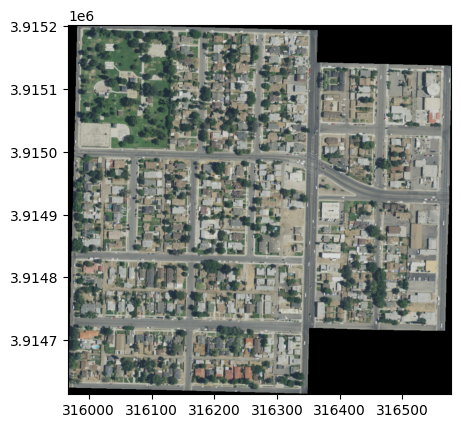

In [215]:
# Display a crop with its metadata

# Get a list of image files in the directory
image_files = os.listdir(crop_dir)

# Select a random image file
random_image_file = random.choice(image_files)

# Define the path to the selected image file
image_path = os.path.join(crop_dir, random_image_file)

# Open the image file
with rasterio.open(image_path) as src:
   
    # print metadata
    print('CRS:', src.crs)
    print('Bands:', src.count)
    print('Width:', src.width)
    print('Height:', src.height)
    print('Bounds:', src.bounds)
    print('Transform:', src.transform)
    print('Data type:', src.dtypes[0])

    # Plot the image
    show(src)

In [9]:
## Generate and save patches from images

def split_image_into_patches(image_path, patch_size):
    image = Image.open(image_path)
    width, height = image.size

    # Calculate the number of patches in each dimension
    num_patches_x = (width + patch_size - 1) // patch_size
    num_patches_y = (height + patch_size - 1) // patch_size

    # Calculate the required padding
    padded_width = num_patches_x * patch_size
    padded_height = num_patches_y * patch_size

    # Pad the image if necessary
    if width != padded_width or height != padded_height:
        pad_width = padded_width - width
        pad_height = padded_height - height
        padding = (0, 0, pad_width, pad_height)
        image = ImageOps.expand(image, padding)

    patches = []
    for y in range(num_patches_y):
        for x in range(num_patches_x):
            # Calculate the coordinates for cropping the patch
            left = x * patch_size
            upper = y * patch_size
            right = left + patch_size
            lower = upper + patch_size

            # Crop the patch
            patch = image.crop((left, upper, right, lower))
            patches.append(patch)

    return patches


def save_patches(patches, image_filename, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Extract the filename without the extension
    filename_without_ext = os.path.splitext(os.path.basename(image_filename))[0]

    # Save each nonzero-prominent patch
    for i, patch in enumerate(patches):
        # Calculate the size of the patch
        patch_size = patch.size[0] * patch.size[1] * 3

        # Calculate the number of non-zero pixels in the patch
        nonzero_count = np.count_nonzero(patch)

        # Calculate the fraction of zero values in the patch
        zero_fraction = (patch_size - nonzero_count) / patch_size

        # Check if the patch is at least half zeros, and skip if so
        if zero_fraction >= 0.5:
            continue  # Skip saving the patch

        # Generate the patch filename
        patch_filename = f"{filename_without_ext}_{i}.tif"

        # Save the patch
        patch.save(os.path.join(output_dir, patch_filename))


def split_images_and_save_patches(input_dir, output_dir, patch_size):
    # Find all image files in the input directory
    image_files = glob.glob(os.path.join(input_dir, "*.tif"))

    for image_file in image_files:
        # Split the image into patches
        patches = split_image_into_patches(image_file, patch_size)

        # Save the patches
        save_patches(patches, image_file, output_dir)

# Set the input directory, output directory, and patch size
input_dir = "../data/crops"
output_dir = "../data/patches"
patch_size = 512

# Split images into patches and save them
split_images_and_save_patches(input_dir, output_dir, patch_size)

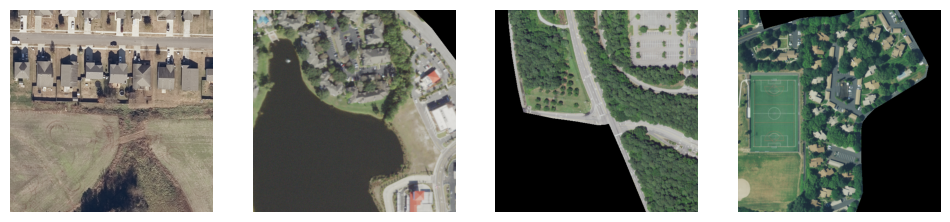

In [19]:
## View a random selections of patches

def view_random_patches(patches_dir, num_patches):
    patch_files = os.listdir(patches_dir)

    # Select random patches
    selected_patches = random.sample(patch_files, num_patches)

    # Display the selected patches
    fig, axes = plt.subplots(1, num_patches, figsize=(12, 4))

    for i, patch_filename in enumerate(selected_patches):
        patch_path = os.path.join(patches_dir, patch_filename)
        patch = Image.open(patch_path)
        axes[i].imshow(patch)
        axes[i].axis('off')

    plt.show()

# Set the directory containing the saved patches
patches_dir = "../data/patches"

# Set the number of random patches to view
num_patches = 4

# View randomly selected patches
view_random_patches(patches_dir, num_patches)

Training set size: 237603
Validation set size: 50915
Testing set size: 50916


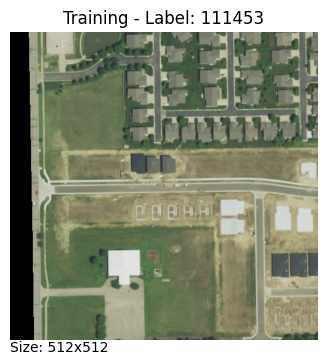

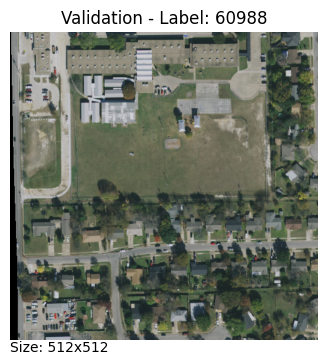

Text(0, 512, 'Size: 512x512')

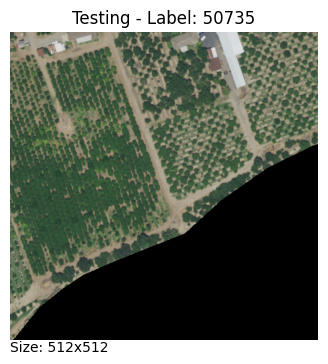

In [20]:
## Load and display image data
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = generate_dataset('patches')

# Select a random image from the training dataset
train_idx = random.randint(0, len(train_dataset) - 1)
train_image, train_label = train_dataset[train_idx]
plt.figure(figsize=(4, 4))
plt.imshow(train_image.permute(1, 2, 0))
plt.title(f"Training - Label: {train_label}")
plt.axis('off')
plt.text(0, train_image.shape[1], f"Size: {train_image.shape[1]}x{train_image.shape[2]}", fontsize=10, ha='left', va='top')
plt.show()

# Select a random image from the validation dataset
val_idx = random.randint(0, len(val_dataset) - 1)
val_image, val_label = val_dataset[val_idx]
plt.figure(figsize=(4, 4))
plt.imshow(val_image.permute(1, 2, 0))
plt.title(f"Validation - Label: {val_label}")
plt.axis('off')
plt.text(0, val_image.shape[1], f"Size: {val_image.shape[1]}x{val_image.shape[2]}", fontsize=10, ha='left', va='top')
plt.show()

# Select a random image from the testing dataset
test_idx = random.randint(0, len(test_dataset) - 1)
test_image, test_label = test_dataset[test_idx]
plt.figure(figsize=(4, 4))
plt.imshow(test_image.permute(1, 2, 0))
plt.title(f"Testing - Label: {test_label}")
plt.axis('off')
plt.text(0, test_image.shape[1], f"Size: {test_image.shape[1]}x{test_image.shape[2]}", fontsize=10, ha='left', va='top')

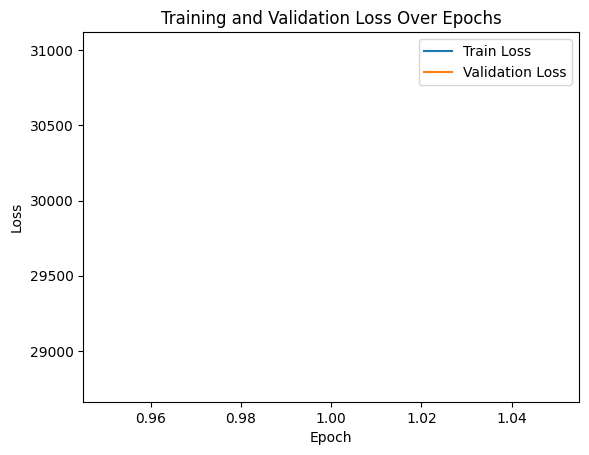

In [3]:
## Load model and show training history

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
gc.collect()

# Load model architechture
train_all = True
model, criterion = generate_resnet(device, train_all)

# Load the best model
checkpoint = torch.load('../saved_models/2023-05-19_20-24-01/FC_1_28774.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Load its history
history = checkpoint['history']
train_losses = history['train_losses']
val_losses = history['val_losses']

# Plot train and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [7]:
# Test
model.eval()
test_loss = 0.0
predictions = []
ground_truths = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predictions.extend(outputs.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Calculate evaluation metrics
mse = mean_squared_error(ground_truths, predictions)
rmse = math.sqrt(mse)
r2 = r2_score(ground_truths, predictions)

# Print evaluation metrics
print("Test Loss (MAE): {:.0f}".format(test_loss))
print("Mean Squared Error (MSE): {:.0f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.0f}".format(rmse))
print("R-squared (R2): {:.3f}".format(r2))

Test Loss (MAE): 28678
Mean Squared Error (MSE): 1574638895
Root Mean Squared Error (RMSE): 39682
R-squared (R2): 0.177


In [4]:
## LIME

def lime_explain(image, model, num_samples=1000, num_features=100, top_labels=1):

    # Convert the image tensor to a NumPy array
    image = image.numpy()

    # Convert the image to 8-bit integer type
    image = image.transpose((1, 2, 0)).astype(np.uint8)

    # Segment the image using QuickShift
    segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

    # Generate perturbed versions of the image
    perturbations = np.random.randint(0, 256, size=(num_samples, image.shape[0], image.shape[1], image.shape[2]), dtype=np.uint8)

    # Generate perturbed segmentations
    perturbed_segmentations = []
    for perturbation in perturbations:
        perturbed_segments = quickshift(perturbation, kernel_size=4, max_dist=200, ratio=0.2)
        perturbed_segmentations.append(perturbed_segments)

    # Convert the images and segmentations to tensors
    image_tensor = torch.from_numpy(image.transpose((2, 0, 1))).unsqueeze(0).float()
    perturbations_tensor = torch.from_numpy(np.array(perturbations).transpose((0, 3, 1, 2))).float()

    # Move tensors to the device
    image_tensor = image_tensor.to(device)
    perturbations_tensor = perturbations_tensor.to(device)

    # Get model predictions for the original image and perturbed images
    original_output = model(image_tensor).squeeze(0)
    perturbed_outputs = model(perturbations_tensor).squeeze(1)

    # Compute distances between the original output and perturbed outputs
    distances = torch.norm(original_output - perturbed_outputs, dim=1)

    # Sort the distances and select the top segmentations
    top_indices = distances.argsort()[:num_samples]

    # Select the top segmentations and their corresponding perturbed segmentations
    top_segmentations = [segments] + [perturbed_segmentations[i] for i in top_indices]
    top_images = [image] + [perturbations[i] for i in top_indices]

    # Generate the feature matrix
    feature_matrix = np.zeros((num_samples + 1, num_features))
    for i, segmentation in enumerate(top_segmentations):
        for segment in np.unique(segmentation):
            mask = (segmentation == segment)
            feature_matrix[i, segment] = np.mean(mask)

    # Generate the label vector
    label_vector = np.zeros(num_samples + 1)
    label_vector[0] = model(image_tensor).item()
    for i, perturbed_output in enumerate(perturbed_outputs[top_indices]):
        label_vector[i + 1] = perturbed_output.item()

    # Fit a linear regression model to explain the predictions
    explainer = LinearRegression()
    explainer.fit(feature_matrix, label_vector)

    # Compute the importance scores for each segment
    importance_scores = explainer.coef_[1:]

    # Normalize the importance scores
    importance_scores /= np.abs(importance_scores).sum()

    return top_images, top_segmentations, importance_scores

# Select a random image from the test set
random_idx = np.random.randint(len(test_dataset))
image, label = test_dataset[random_idx]

# Call the LIME function to obtain explanations
lime_images, lime_segmentations, importance_scores = lime_explain(image, model)

# Print the ground truth label and the predicted label
print("Ground Truth Label:", label)
print("Predicted Label:", model(image.to(device)).item())

# Display the original image
plt.subplot(1, len(lime_images)+1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Display the lime images and their corresponding explanations
for i, lime_image in enumerate(lime_images):
    plt.subplot(1, len(lime_images)+1, i+2)
    plt.imshow(lime_image)
    plt.imshow(lime_segmentations[i], cmap='jet', alpha=0.5)
    plt.title(f"Explained Image {i+1}\nImportance: {importance_scores[i]:.2f}")
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 15.62 GiB (GPU 0; 14.61 GiB total capacity; 3.55 GiB already allocated; 10.14 GiB free; 3.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
## Reserved code below ##

In [ ]:
## Create dataset in which patches are stored on same tensor

class ImageDataset(Dataset):
    def __init__(self, data_folder, patch_size, transform=None):
        self.data_folder = data_folder
        self.patch_size = patch_size
        self.transform = transform
        
        # Get the list of image files and their corresponding labels
        self.image_files = []
        self.labels = []
        for filename in os.listdir(data_folder):
            if filename.endswith(".tif"):
                self.image_files.append(filename)
                label = float(filename.split('_')[-1].split('.')[0])
                self.labels.append(label)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load the image and convert to a PIL Image object
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        try:
            image_path = os.path.join(self.data_folder, self.image_files[idx])
            image = Image.open(image_path)
        except Image.DecompressionBombError:
            print("Skipped an image due to a decompression bomb.")
            return None, None, None, None

        # Get the width and height of the image
        width, height = image.size
        #print(f'old_width: {width}, old height: {height}')

        # Calculate the padding values to reach a multiple of the patch size
        pad_width = (self.patch_size - (width % self.patch_size)) % self.patch_size
        pad_height = (self.patch_size - (height % self.patch_size)) % self.patch_size

        # Pad the image
        padded_image = ImageOps.expand(image, (pad_width, pad_height))

        # Compute the new width and height after padding
        new_width = width + pad_width
        new_height = height + pad_height
        #print(f'new width: {new_width}, new height: {new_height}')

        # Compute the number of patches in the x and y directions
        n_patches_x = int(new_width / self.patch_size)
        n_patches_y = int(new_height / self.patch_size)

        # Initialize a list to store the image patches
        patches = []

        # Loop over the patches and extract each one
        for j in range(n_patches_y):
            for i in range(n_patches_x):
                x0 = i * self.patch_size
                y0 = j * self.patch_size
                x1 = x0 + self.patch_size
                y1 = y0 + self.patch_size
                patch = padded_image.crop((x0, y0, x1, y1))
                if self.transform:
                    patch = self.transform(patch)
                patches.append(patch)

        # Convert the list of patches to a tensor
        patches = torch.stack(patches)

        # Get the label for this image
        label = self.labels[idx]

        return patches, label, new_width, new_height


# Define the path to the folder with the cropped images and their labels
data_folder = "../data/crops"

# Define the patch size for the image patches
patch_size = 512

# Define the transform to be applied to each image patch
transform = transforms.Compose([
    transforms.ToTensor()
])

# Initialize a dataset object for the cropped images and their labels
dataset = ImageDataset(data_folder, patch_size, transform=transform)

torch.Size([9, 3, 512, 512])
Label: 236042.0


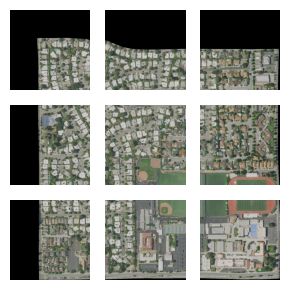

In [298]:
# Define a function to display a grid of images
def show_images(images, new_width, new_height):
    num_images = images.shape[0]
    num_cols = int(new_width / patch_size)
    num_rows = int(new_height / patch_size)
    figsize = (num_cols, num_rows)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Handle cases when axes is a 2D array or a single Axes object
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i < num_images:
            image = images[i].permute(1, 2, 0).numpy()
            ax.imshow(image)
            ax.axis('off')
        else:
            # If there are more axes than images, hide the extra axes
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Get a batch of image patches from an image in the dataset
patches, label, new_width, new_height = dataset[377]

# Display the image patches
print(patches.size())
print(f'Label: {label}')
show_images(patches, new_width, new_height)